In [1]:
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")

os.environ["NUMEXPR_NUM_THREADS"] = "10"

In [2]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from hydra import compose, initialize

plt.style.use("ggplot")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from src.preprocessing import ClassicDataset
from src.utils.processing import train_test_split

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)
libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS
2024-02-08 23:59:16.914537: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 23:59:16.945180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 23:59:16.945204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 23:59:16.946676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-0

In [3]:
# Paths and file names
config_path = os.path.join("..", "..", "config", "dataset")
config_files = [
    os.path.splitext(f)[0]
    for f in os.listdir(os.path.join(os.path.abspath("."), config_path[6:]))
    if f.endswith(".yaml")
]

In [4]:
def get_dataset_features(
    ratings: pd.DataFrame,
    user_id: str = "userId",
    item_id: str = "itemId",
    rating_col: str = "rating",
) -> dict:
    """
    Calculate various features from the ratings DataFrame.

    Parameters:
        ratings (pd.DataFrame): DataFrame containing user-item ratings.
        user_id (str): Name of the column representing user IDs.
        item_id (str): Name of the column representing item IDs.
        rating_col (str): Name of the column representing ratings.

    Returns:
        dict: A dictionary containing calculated features.
    """
    # 1-3 Basic features
    U = ratings[user_id].nunique()
    I = ratings[item_id].nunique()
    R = ratings.shape[0]

    # 4 SpaceSize
    SpaceSize = U * I

    # 5 Shape
    Shape = U / I

    # 6  Density
    Density = R / SpaceSize

    # 7, 8 Rating per user and Rating per item
    Rpu = R / U
    Rpi = R / I

    # 9, 10 Ginii and Giniu
    Ri_counts = ratings[item_id].value_counts().values[::-1]
    Ru_counts = ratings[user_id].value_counts().values[::-1]
    Ginii = 1 - 2 * np.sum((I + 1 - np.arange(1, I + 1)) * Ri_counts) / ((I + 1) * R)
    Giniu = 1 - 2 * np.sum((U + 1 - np.arange(1, U + 1)) * Ru_counts) / ((U + 1) * R)

    # 11-14 Polularity biases
    avg_item_popularity = ratings.groupby(item_id)[user_id].nunique() / U
    ratings = ratings.join(
        avg_item_popularity.rename("item_popularity", inplace=False), on=item_id
    )
    popularity_bias = ratings.groupby(user_id)["item_popularity"].mean()
    APB = popularity_bias.mean()
    StPB = popularity_bias.std()
    SkPB = skew(popularity_bias)
    KuPB = kurtosis(popularity_bias)

    # 15-18 Long tail items
    item_popularity = ratings[item_id].value_counts()
    item_popularity_cumsum = item_popularity.cumsum()
    LT_index = np.argmax(item_popularity_cumsum / R > 0.8)
    LT_items = set(item_popularity.iloc[LT_index:].index)
    LT_items_percentage = ratings.groupby(user_id)[item_id].apply(
        lambda x: len(set(x) & LT_items) / len(set(x)) if len(set(x)) > 0 else 0
    )
    LTavg = LT_items_percentage.mean()
    LTstd = LT_items_percentage.std()
    LTsk = skew(LT_items_percentage)
    LTku = kurtosis(LT_items_percentage)

    return {
        "Nu": U,
        "Ni": I,
        "Nr": R,
        "SpaceSize": SpaceSize,
        "Shape": Shape,
        "Density": Density,
        "Rpu": Rpu,
        "Rpi": Rpi,
        "Ginii": Ginii,
        "Giniu": Giniu,
        "APB": APB,
        "StPB": StPB,
        "SkPB": SkPB,
        "KuPB": KuPB,
        "LTavg": LTavg,
        "LTstd": LTstd,
        "LTsk": LTsk,
        "LTku": LTku,
    }

In [5]:
files_to_filter = [
    "tmall",
    "twitch",
    "xwines",
    "yahoo",
    "yoochoose",
    "otto",
    "lfm",
    "hotelrec",
    "movielens_100k",
    "amazon_books",
    "sber_bank",
]
filtered_config_files = [file for file in config_files if file not in files_to_filter]

In [ ]:
statistics_wo_cold_iu = dict()
for config_file in tqdm(
    filtered_config_files, desc=f"Processing {config_file} dataset"
):
    with initialize(config_path=str(config_path), version_base=None):
        cfg_data = compose(config_name=str(config_file))
    # init some constants
    user_id = "userId"
    item_id = "itemId"
    rating_col = "rating"
    date_col = "timestamp"

    train_set = Path("preproc_data", cfg_data["name"], "train.parquet")
    test_set = Path("preproc_data", cfg_data["name"], "test.parquet")

    if not train_set.exists() or not test_set.exists():
        dataset = ClassicDataset()
        dataset.prepare(cfg_data)
        data_train, data_test = train_test_split(
            dataset.prepared_data,
            test_size=0.1,
            splitting_type="temporal",
        )
        data_train.to_parquet(train_set)
        data_test.to_parquet(test_set)

    # get raw data
    train_set = pd.read_parquet(train_set)

    test_set = pd.read_parquet(test_set)

    # get splitted and filtered dataset features
    data_splitted = pd.concat([train_set, test_set])
    data_splitted.reset_index(drop=True, inplace=True)

    statistics_wo_cold_iu[cfg_data["name"]] = get_dataset_features(
        data_splitted,
    )

    # some additional features
    statistics_wo_cold_iu[cfg_data["name"]]["FracInteractionsTest"] = len(test_set) / (
        len(data_splitted)
    )

    statistics_wo_cold_iu[cfg_data["name"]]["FracPassiveUsersTest"] = test_set[
        user_id
    ].nunique() / (data_splitted[user_id].nunique())

    statistics_wo_cold_iu[cfg_data["name"]]["FracPassiveItemsTest"] = test_set[
        item_id
    ].nunique() / (data_splitted[item_id].nunique())

    # timestamps
    # full data
    if len(str(int(data_splitted[date_col][0]))) > 11:
        unit = "ns"
    elif len(str(int(data_splitted[date_col][0]))) > 6:
        unit = "s"
    else:
        unit = "W"

    date_col = "timestamp"

    data_splitted[date_col] = pd.to_datetime(data_splitted[date_col], unit=unit)
    statistics_wo_cold_iu[cfg_data["name"]]["MinDate"] = (
        data_splitted[date_col].min().to_pydatetime()
    )
    statistics_wo_cold_iu[cfg_data["name"]]["MaxDate"] = (
        data_splitted[date_col].max().to_pydatetime()
    )

    # test Set
    test_set[date_col] = pd.to_datetime(test_set[date_col], unit=unit)
    statistics_wo_cold_iu[cfg_data["name"]]["TestDate"] = (
        test_set[date_col].min().to_pydatetime()
    )
    statistics_wo_cold_iu[cfg_data["name"]]["DeltaTest"] = (
        test_set[date_col].max() - test_set[date_col].min()
    ).days

In [26]:
with open(
    os.path.join("results", "datasets_statistics", "statistics_wo_cold_iu.pcl"), "wb"
) as f:
    pickle.dump(statistics_wo_cold_iu, f)

In [28]:
# Convert the dictionary to a pandas DataFrame
statistics_wo_cold_iu_df = pd.DataFrame(statistics_wo_cold_iu).T

In [29]:
statistics_wo_cold_iu_df.keys()

Index(['Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu', 'Rpi',
       'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg', 'LTstd',
       'LTsk', 'LTku', 'FracInteractionsTest', 'FracPassiveUsersTest',
       'FracPassiveItemsTest', 'MinDate', 'MaxDate', 'TestDate', 'DeltaTest'],
      dtype='object')

In [30]:
statistics_wo_cold_iu_df.SpaceSize.sort_values()

foursquare               394548
kuairec_small           4412197
douban_music            5221560
douban_books            8747200
reddit                 15559680
movielens_1m           18632370
douban_movies          35345200
kuairec_full           62818704
rekko                  83760012
brightkite            147650202
amazon_finefoods      189994360
beeradvocate          231054001
ratebeer              260954800
amazon_mi             282991985
epinions              389330500
tafeng                394277380
dianping              557775972
movielens_10m         568156116
food                  765101590
retail               1659071604
movielens_20m        1758668226
mts_library          4126850094
netflix              7740467190
amazon_cds           8054769762
goodreads            8711180902
amazon_tv           10769061600
gowalla             11035202529
sber_zvuk           17702702562
yelp                19414532085
sber_smm            30892471680
Name: SpaceSize, dtype: object

In [31]:
statistics_wo_cold_iu_df.SpaceSize.sort_values()[::-1]

sber_smm            30892471680
yelp                19414532085
sber_zvuk           17702702562
gowalla             11035202529
amazon_tv           10769061600
goodreads            8711180902
amazon_cds           8054769762
netflix              7740467190
mts_library          4126850094
movielens_20m        1758668226
retail               1659071604
food                  765101590
movielens_10m         568156116
dianping              557775972
tafeng                394277380
epinions              389330500
amazon_mi             282991985
ratebeer              260954800
beeradvocate          231054001
amazon_finefoods      189994360
brightkite            147650202
rekko                  83760012
kuairec_full           62818704
douban_movies          35345200
movielens_1m           18632370
reddit                 15559680
douban_books            8747200
douban_music            5221560
kuairec_small           4412197
foursquare               394548
Name: SpaceSize, dtype: object

In [32]:
data = statistics_wo_cold_iu_df[
    [
        "Nu",
        "Ni",
        "Nr",
        "SpaceSize",
        "Shape",
        "Density",
        "Rpu",
        "Rpi",
        "Ginii",
        "Giniu",
        "APB",
        "StPB",
        "SkPB",
        "KuPB",
        "LTavg",
        "LTstd",
        "LTsk",
        "LTku",
    ]
]

In [33]:
data.shape

(30, 18)

In [34]:
data.to_csv(
    os.path.join("results", "datasets_statistics", "statistics_df.csv"), index=True
)

In [37]:
data_scaled = pd.DataFrame(
    StandardScaler().fit_transform(data), data.index, data.columns
)

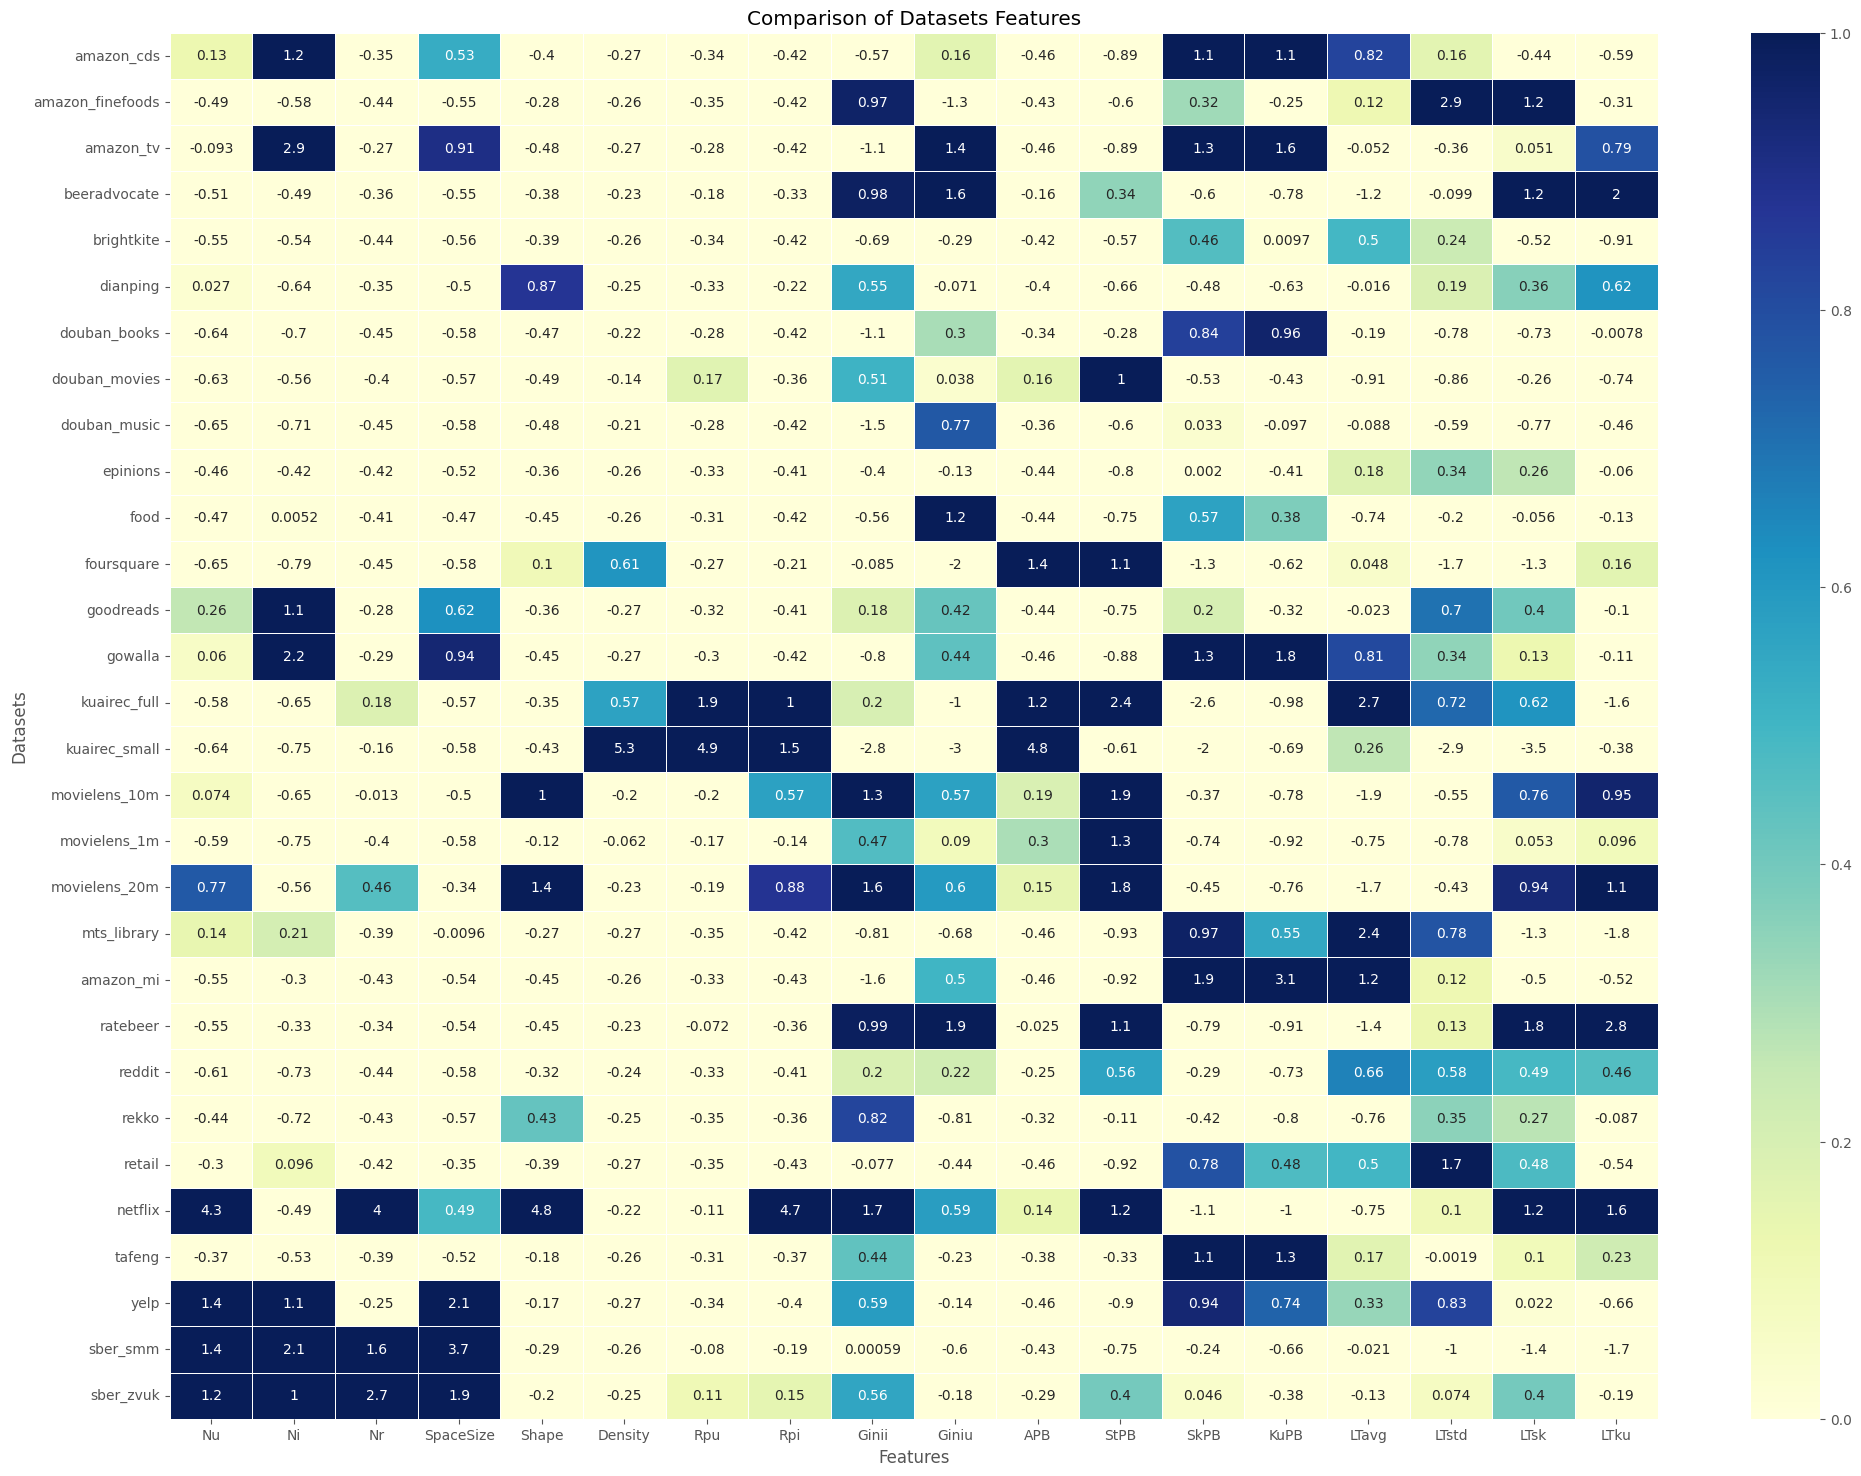

In [38]:
plt.figure(figsize=(24, 18))
sns.heatmap(data_scaled, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5)
plt.title("Comparison of Datasets Features")
plt.xlabel("Features")
plt.ylabel("Datasets")
plt.show()

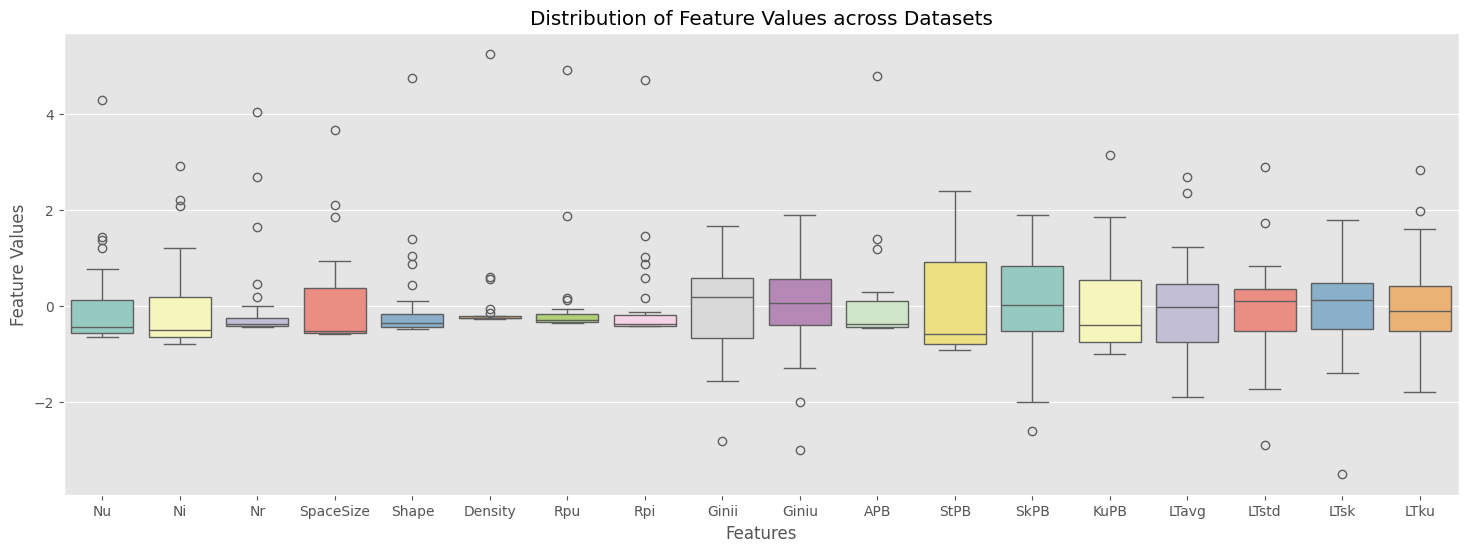

In [42]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=data_scaled, palette="Set3")
plt.title("Distribution of Feature Values across Datasets")
plt.xlabel("Features")
plt.xticks(rotation=0)
plt.ylabel("Feature Values")
plt.show()

In [50]:
data_scaled = data_scaled[
    [
        "SpaceSize",
        "Shape",
        "Density",
        "Nu",
        "Ni",
        "Nr",
        "Rpu",
        "Rpi",
        "Giniu",
        "Ginii",
        "APB",
        "StPB",
        "SkPB",
        "KuPB",
        "LTavg",
        "LTstd",
        "LTsk",
        "LTku",
    ]
]

/home/jovyan/anaconda3/envs/recsys/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/anaconda3/envs/recsys/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/anaconda3/envs/recsys/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/anaconda3/envs/recsys/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jovyan/anaconda3/e

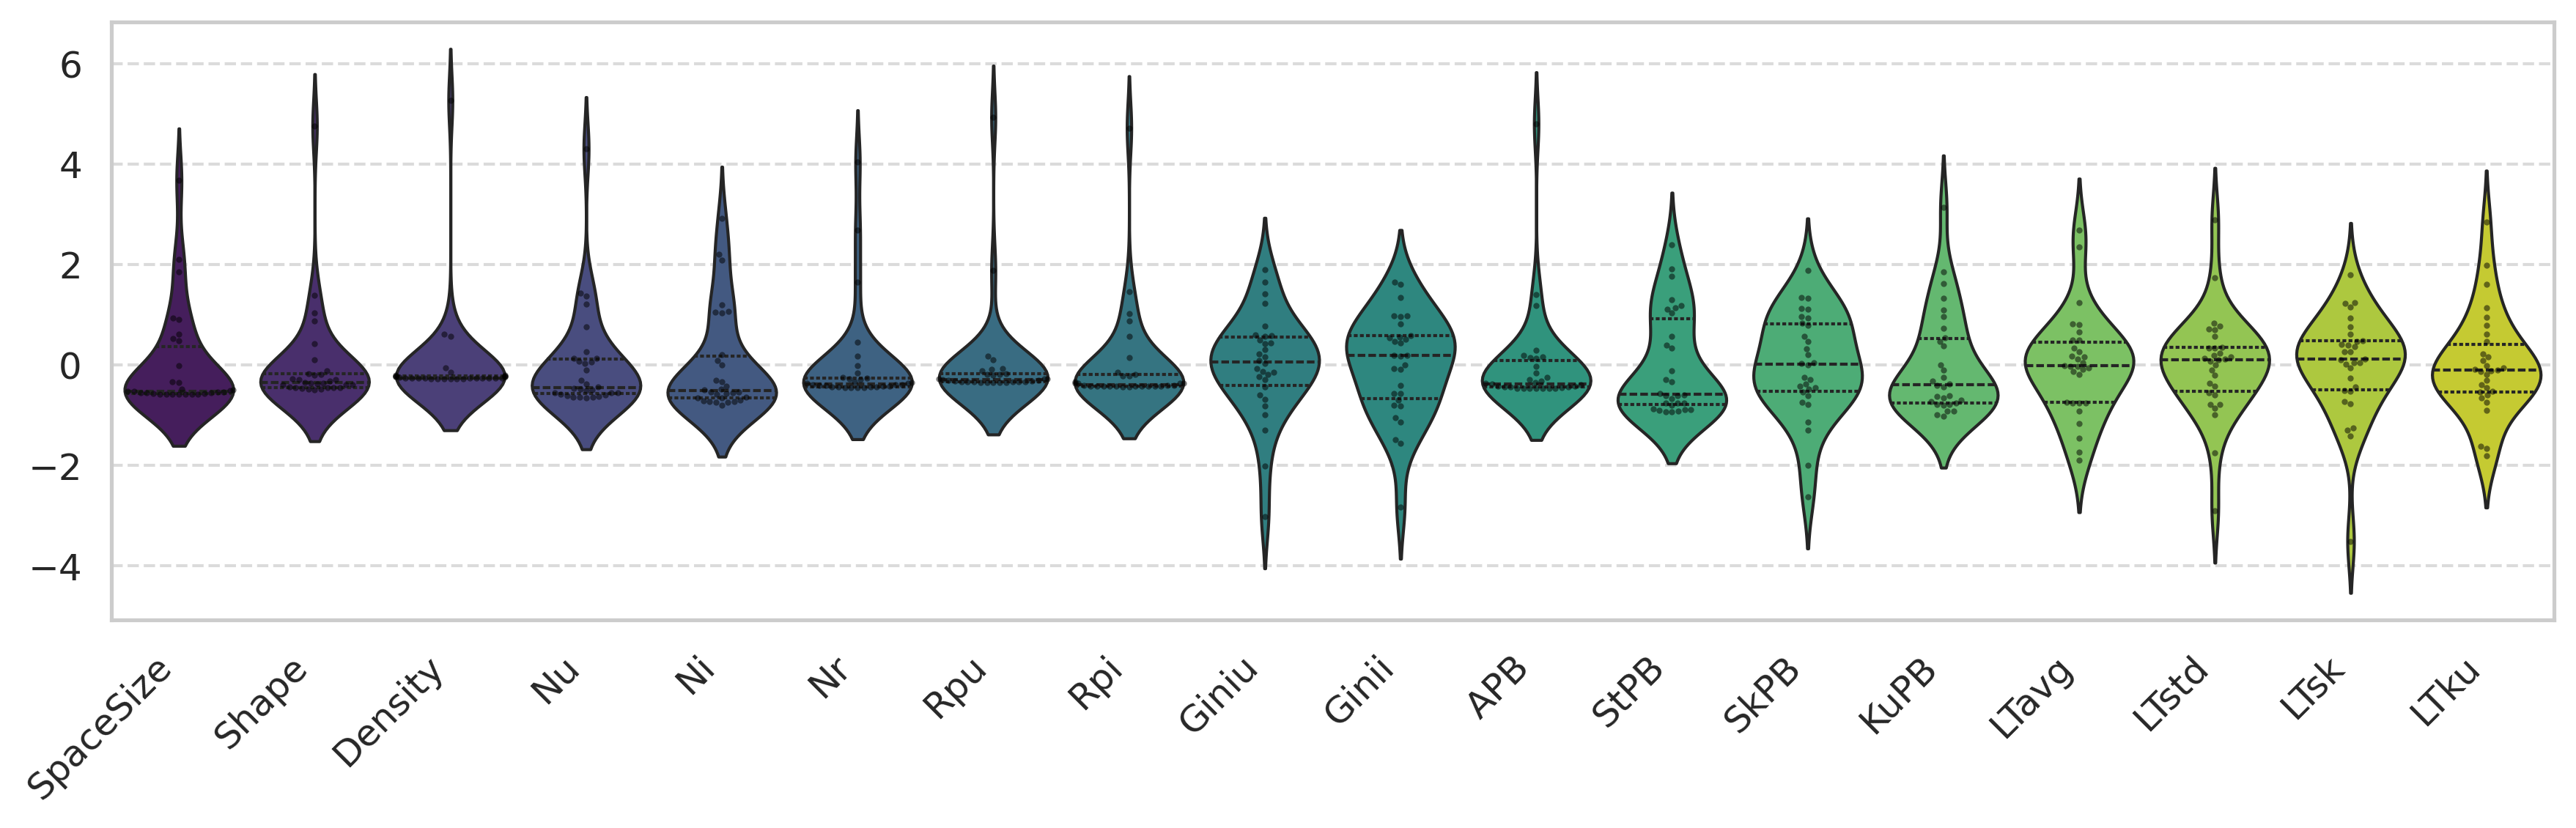

In [56]:
# Set style and palette
sns.set(style="whitegrid", font_scale=1.2)
sns.set_palette("mako")  # You can choose a different color palette

# Create a figure with appropriate size and resolution
plt.figure(figsize=(12, 4), dpi=300)

# Use the swarmplot in addition to violinplot for better visibility of individual data points
sns.violinplot(
    data=data_scaled, inner="quart", linewidth=1, width=0.8, cut=2, palette="viridis"
)
sns.swarmplot(data=data_scaled, color="black", alpha=0.5, size=2)

# Set title and labels
# plt.title("Distribution of Feature Values across Datasets", fontsize=16)
# plt.xlabel("Features", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
# plt.ylabel("Normalized Feature Values", fontsize=14)

# Customize the y-axis ticks and grid
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add legend or additional text if needed
# plt.legend(["Dataset 1", "Dataset 2"])

# Save the plot with tight layout
plt.tight_layout()
plt.savefig(
    os.path.join("results", "datasets_statistics", "feature_values_plot.pdf"),
    bbox_inches="tight",
)

# Display the plot
plt.show()

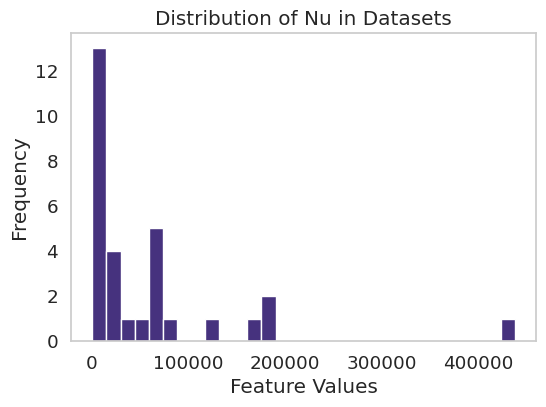

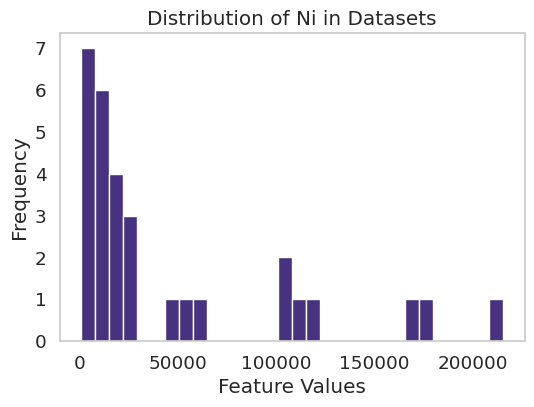

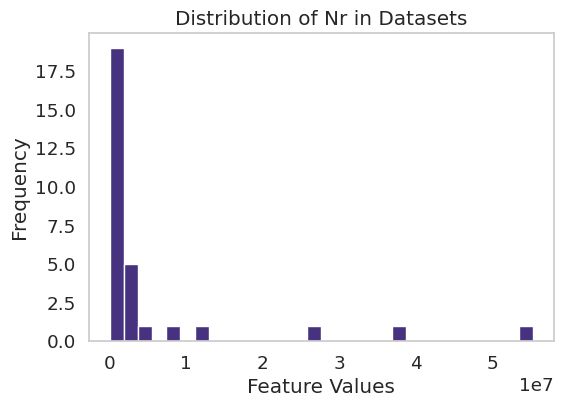

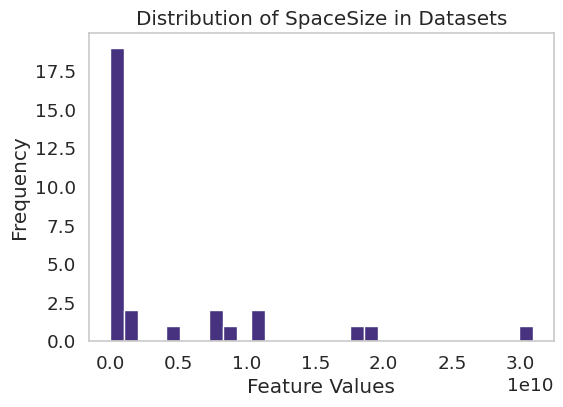

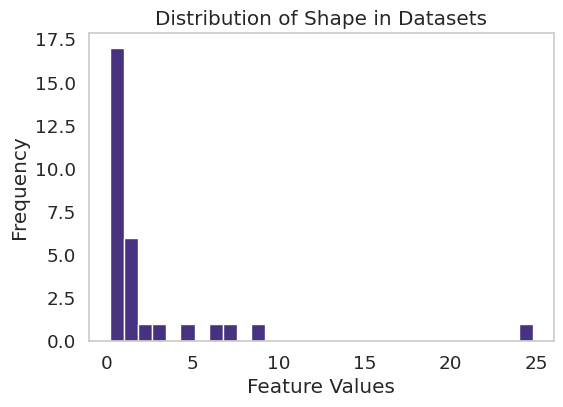

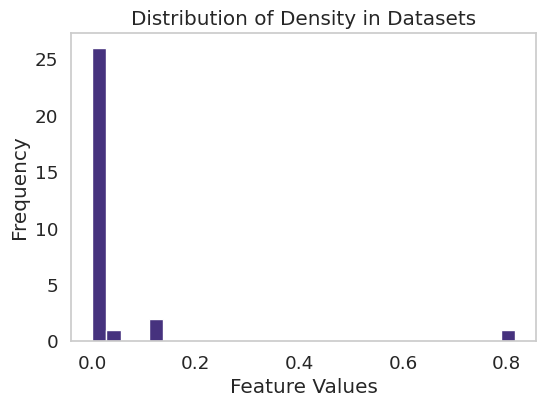

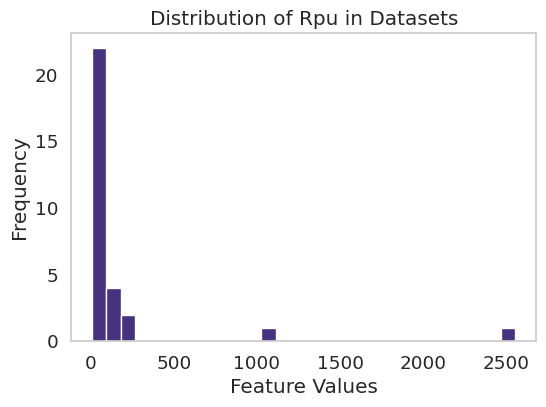

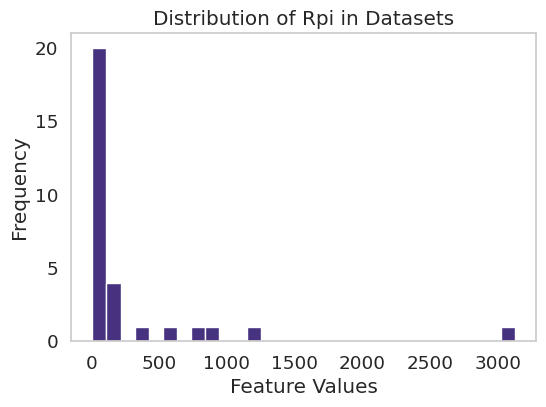

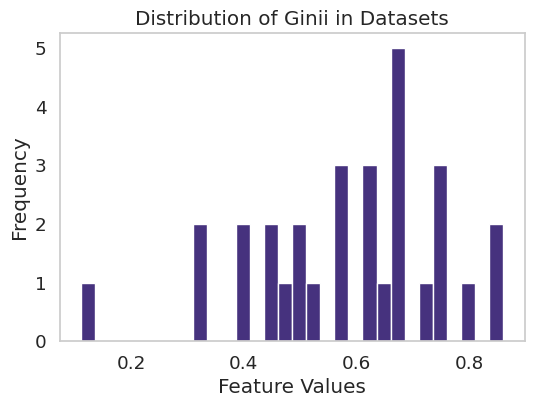

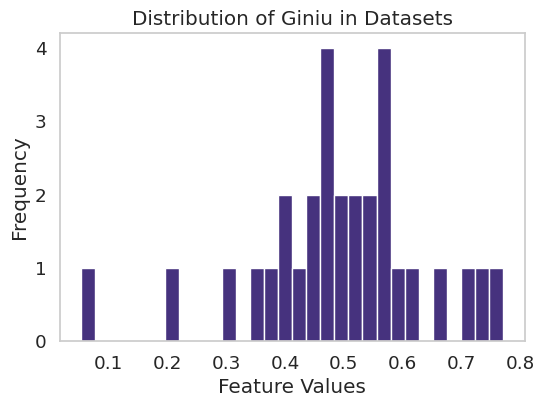

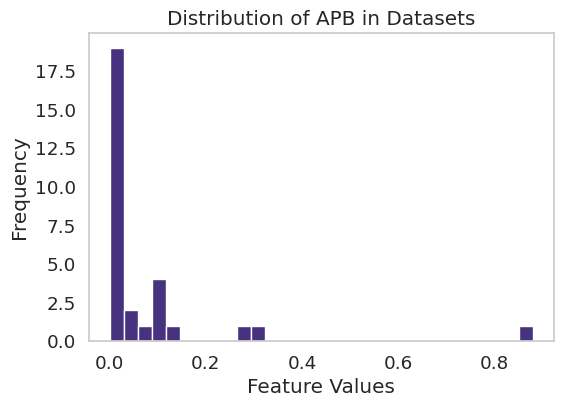

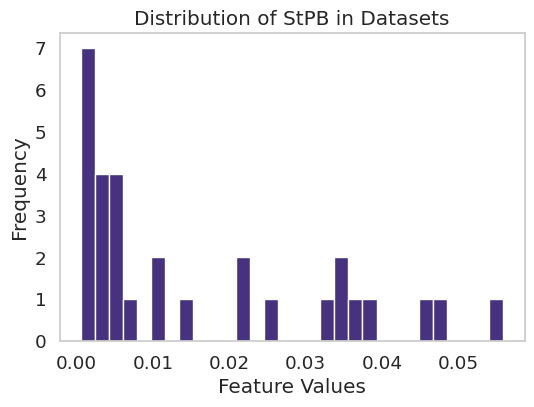

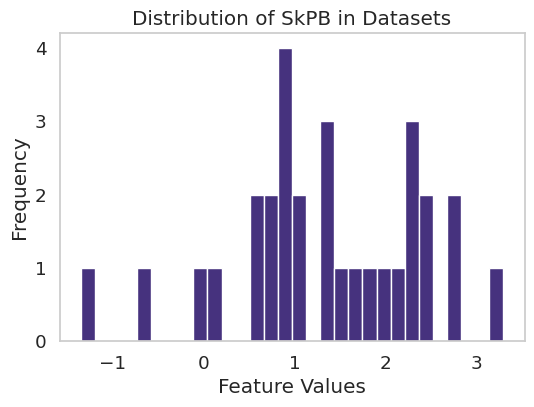

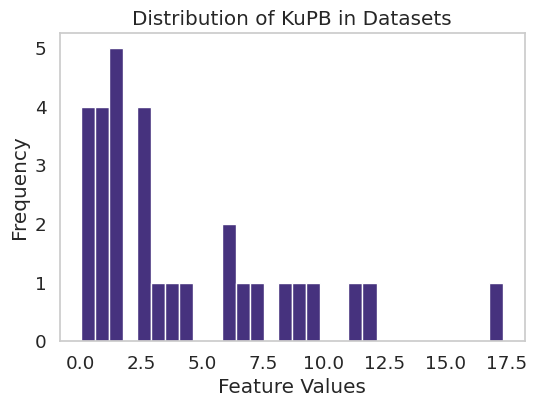

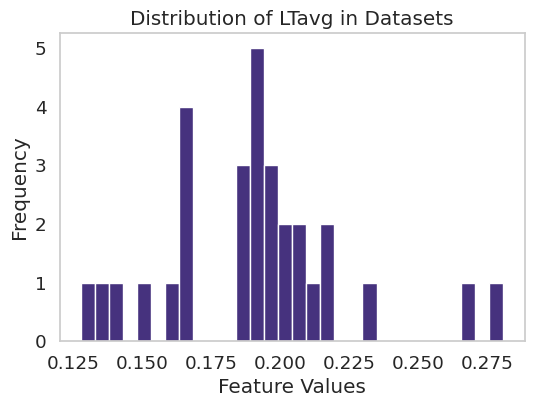

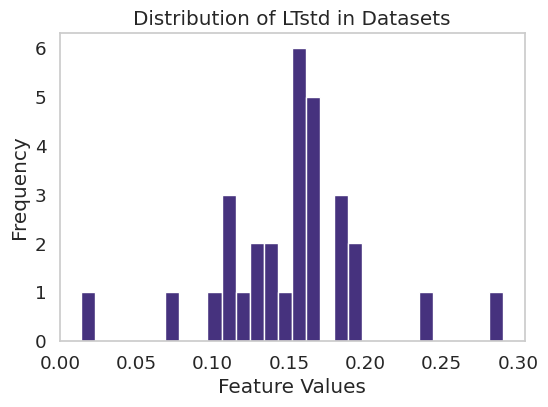

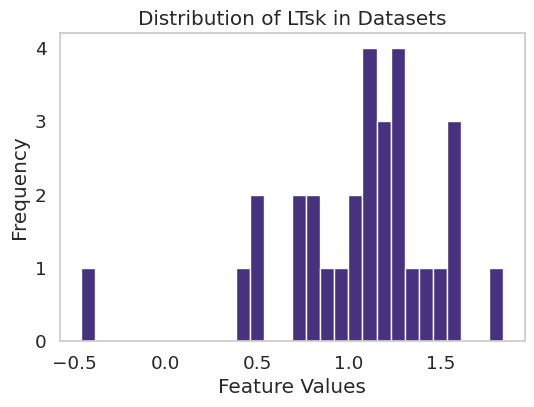

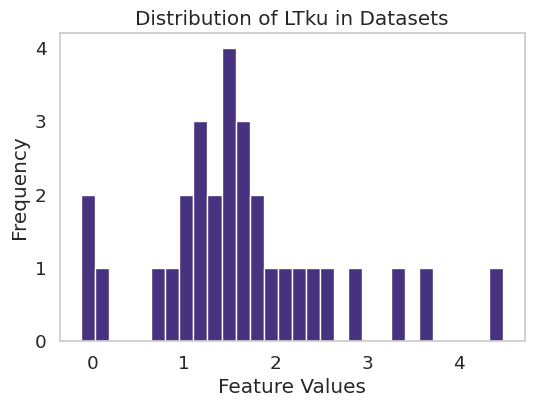

In [34]:
# Create separate figures for each feature's histogram
for feature in data_scaled.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(data[feature], bins=30)
    plt.xlabel("Feature Values")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {feature} in Datasets")
    plt.grid()
    plt.show()